In [25]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler


from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf


import massPy as mp
from utils import get_defect_density, calc_density_fluctuations, get_defect_list

## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [5]:
def get_defect_arr_from_frame(defect_dict):
    """
    Convert dictionary of defects to array of defect positions
    """
    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    defect_positions = np.empty([Ndefects, 2])
    for i, defect in enumerate(defect_dict):
        defect_positions[i] = defect['pos']
    return defect_positions

In [ ]:
## TODO:
# - make corr func mem efficient
# - make a sfactor for all frames
# - find k scaling for sfactor
# - lav plottefunktion dynamisk
# +++ understand params

In [121]:
def get_pair_corr_function(ar, ball_window, frame_interval = None, rmax = 10, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=dict(rmax=rmax), fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=dict(rmax=rmax), fv=method_kwargs)
    
    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None):
    """
    Plot pair correlation function
    """
    if pcf_estimated:
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, marker = '.')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

In [44]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'

data_dirs = os.listdir(path)
data_dirs = [os.path.join(path, d) for d in data_dirs]
ar = mp.archive.loadarchive(data_dirs[2])

In [42]:
data_dirs[2]

'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\qzk1k30.05_K30.05_qkbt0_z0.1_xi1_LX256_counter0'

In [157]:
def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50, plot = False):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    if plot:
        fig, ax = plt.subplots()
        ax = sf.plot_non_isotropic_estimator(
        k,
        sf_estimated,
        plot_type="radial",
        error_bar=True,
        bins=nbins,
        scale="log",
        label=r"$\widehat{S}_{\mathrm{SI}}(\mathbf{k})$",)

        x = np.linspace(0.01, 0.4, 100  )
        plt.plot(x, x**0.1, label=r'$k^{0.1}$')
        plt.plot(x, x**0.2, label=r'$k^{0.2}$')
        plt.plot(x, x**0.3, label=r'$k^{0.3}$')
        plt.errorbar(kbins, smeans, yerr=sstds, fmt='s-', label='Density variance', alpha=1, markersize=12)
        plt.legend()

        plt.tight_layout(pad=1)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(k, sf_estimated, kbins, smeans, sstds, nbins):
    """
    Plot structure factor
    """
    fig, ax = plt.subplots()

  #  ax.plot(kbins[:], np.exp(fit_func(np.log(kbins)[:], *fit.values[:])), label='Fit')
    ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=1, alpha=0.2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([0.01, 10])
    ax.set_xlim([0.01, 0.6])
    ax.set_xticks([5e-3, 1e-2, 1e-1, 1e0])
    ax.set_yticks([1e-2, 1e-1, 1e0, 1e1])

    x = np.linspace(0.01, 0.4, 100  )
    ax.hlines(1, 0.01, 0.4, label=r'Possion', linestyles='dashed', colors='k')
    ax.plot(x, x**0.1, label=r'$k^{0.1}$')
    ax.plot(x, x**0.2, label=r'$k^{0.2}$')
    ax.plot(x, x**0.3, label=r'$k^{0.3}$')
    ax.errorbar(kbins, smeans, yerr=sstds, fmt='s-', label='Binned means', alpha=.8, color='red', ecolor='black', markersize=5)
    ax.legend()
    ax.set_xlabel(r'$|k|$')
    ax.set_ylabel(r'$S(k)$')
    ax.set_title('Scaling of structure factor with $k$')
    fig.tight_layout(pad=1)

    return fig, ax



In [123]:
Nframe = 130
frame = ar._read_frame(Nframe)
LX, LY = frame.LX, frame.LY
Qxx_dat = frame.QQxx.reshape(LX, LY)
Qyx_dat = frame.QQyx.reshape(LX, LY)
defects = mp.nematic.nematicPy.get_defects(Qxx_dat, Qyx_dat, LX, LY)
window = BoxWindow(bounds=[[0, LX], [0, LY]])   
# Step 1: Convert list of dictionaries to array of defect positions
Ndefects = len(defects)

defect_positions = np.empty([Ndefects, 2])
for i, defect in enumerate(defects):
        defect_positions[i] = defect['pos']

In [ ]:
k, sf_estimated, kbins, smeans, sstds = calc_structure_factor(defect_positions, window, 0.4, nbins = 50, plot = True)

In [133]:
k.shape, sf_estimated.shape

((1024, 2), (1024,))

In [162]:
min(np.linalg.norm(k,axis=1))

0.034710022954362235

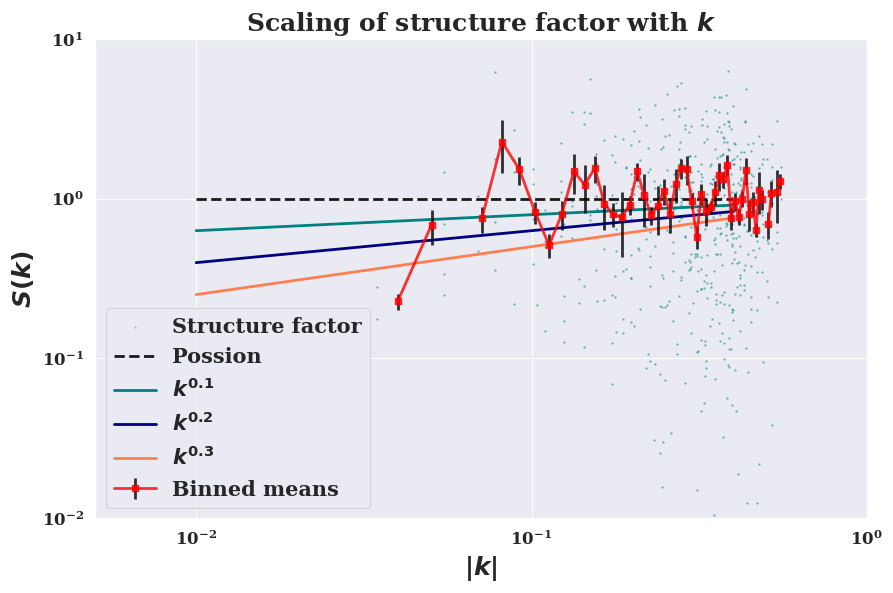

In [158]:
plot_structure_factor(k, sf_estimated, kbins, smeans, sstds, 50);

In [ ]:
frame_interval = [0, 3]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
window = BoxWindow(bounds=[[0, LX], [0, LY]])   
 
point_pattern = PointPattern(defect_positions, window)
sf = StructureFactor(point_pattern)
k, sf_estimated = sf.scattering_intensity(k_max=.8, debiased=True, direct=True)

# Use the family of sine tapers
x = np.linspace(-2, 2, 80)
x = x[x != 0]
#k = meshgrid_to_column_matrix(np.meshgrid(x, x))

knorms = np.linalg.norm(k, axis=1)
kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=50,)

#tapers = multi_sinetaper_grid(point_pattern.dimension, p_component_max=2)
#k, sf_estimated = sf.tapered_estimator(k, tapers=tapers, debiased=True, direct=True)


ax = sf.plot_non_isotropic_estimator(
    k,
    sf_estimated,
    plot_type="radial",
    error_bar=True,
    bins=50,
    scale="log",
    label=r"$\widehat{S}_{\mathrm{SI}}(\mathbf{k})$",
)

x = np.linspace(0.01, 0.4, 100  )
ax.plot(x, x**0.1, label=r'$k^{0.1}$')
ax.plot(x, x**0.2, label=r'$k^{0.2}$')
ax.plot(x, x**0.3, label=r'$k^{0.3}$')
ax.legend()

fig.tight_layout(pad=1)

In [ ]:
frame_interval = [0, 3]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
window = BallWindow(center=[LX/2, LX/2], radius=LX/3) 

rad_arr, pcf_arr = get_pair_corr_function(ar, window, frame_interval = frame_interval, rmax = rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 40))

In [117]:
print("SIZE OF R (MB): ", 1500 * rad_arr.values.itemsize * rad_arr.size  / 1e6)

SIZE OF R (MB):  1.8479999999999999


In [108]:
r_crit = 1.5
Njump_small = 10
Njump_large = 3
idx_crit = np.argmin(np.abs(rad_arr.values - r_crit))

mask = (rad_arr.values < 0)

mask[np.arange(0, idx_crit, Njump_small)] = True
mask[np.arange(idx_crit, len(mask), Njump_large)] = True


print(mask.sum())

154


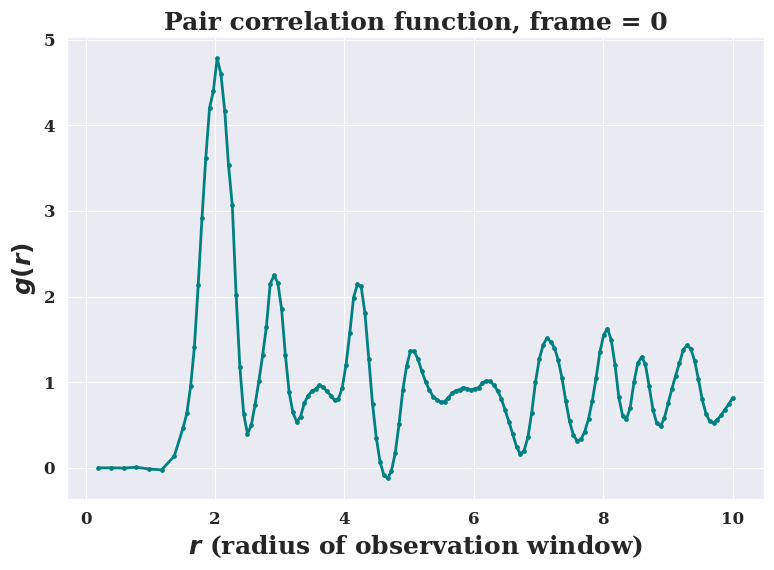

In [109]:
fig, ax = plot_pair_corr_function(rad_arr = rad_arr[mask], pcf_arr = pcf_arr[0][mask], frame = frame_interval[0])